In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# check gpu
print(tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


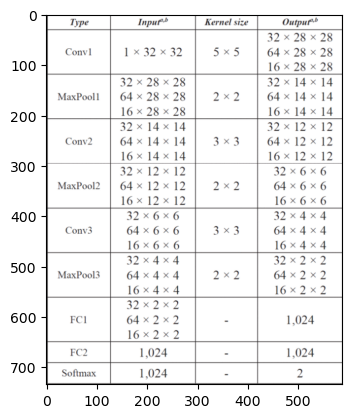

In [3]:
# https://ieeexplore.ieee.org/abstract/document/7440527

img = mpimg.imread('possible_model.png')
plt.imshow(img)
plt.show()

In [ ]:
# physical layer functions

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from skimage.transform import resize

def normalize(img):
    if np.max(img) == 0:
        print('fail')
    img = img / np.max(img)
    img[img < 0.01] = 0
    img = resize(img, (225, 225))
    return img

# reduce resolution with conv
"""the size and number of detector elements, 
the size of the X-ray focal spot, and the
source-object-detector distances"""

lpf = np.ones(shape=(2, 2))
def low_res(img):
    img = sp.signal.convolve2d(img, lpf, mode='same') / lpf.size
    return img

# reduce contrast with norm function
"""voltage (intensity), detector sensitivity"""

def low_contrast(img, gamma=1.0):
    """gamma correction, gamma < 1 is less contrast"""
    res = np.power(img, gamma)
    res = (res - np.min(res)) / (np.max(res) - np.min(res))
    return res

In [ ]:
# load data here
# before we run the models, we should have a way to save them so they don't have to be rerun
# train-test split method or another to get x_train, y_train, x_val, y_val

import os
import numpy as np

In [37]:
print(training_dict)

{'DBT-P00013,rmlo': 'BENIGN', 'DBT-P00023,lcc': 'ACTIONABLE', 'DBT-P00023,lmlo': 'ACTIONABLE', 'DBT-P00023,rcc': 'ACTIONABLE', 'DBT-P00023,rmlo': 'ACTIONABLE', 'DBT-P00024,lcc': 'BENIGN', 'DBT-P00024,lmlo': 'BENIGN', 'DBT-P00029,lcc': 'NORMAL', 'DBT-P00029,lmlo': 'NORMAL', 'DBT-P00029,rcc': 'NORMAL', 'DBT-P00029,rmlo': 'NORMAL', 'DBT-P00032,lcc': 'NORMAL', 'DBT-P00032,lmlo': 'NORMAL', 'DBT-P00032,rcc': 'NORMAL', 'DBT-P00032,rmlo': 'NORMAL', 'DBT-P00045,lcc': 'NORMAL', 'DBT-P00045,lmlo': 'NORMAL', 'DBT-P00045,rcc': 'NORMAL', 'DBT-P00045,rmlo': 'NORMAL', 'DBT-P00052,lcc': 'NORMAL', 'DBT-P00052,lmlo': 'NORMAL', 'DBT-P00052,rcc': 'NORMAL', 'DBT-P00052,rmlo': 'NORMAL', 'DBT-P00060,rcc': 'BENIGN', 'DBT-P00064,lcc': 'NORMAL', 'DBT-P00064,lmlo': 'NORMAL', 'DBT-P00064,rcc': 'NORMAL', 'DBT-P00064,rmlo': 'NORMAL', 'DBT-P00076,lcc': 'NORMAL', 'DBT-P00076,lmlo': 'NORMAL', 'DBT-P00076,rcc': 'NORMAL', 'DBT-P00076,rmlo': 'NORMAL', 'DBT-P00107,lcc': 'CANCER', 'DBT-P00107,lmlo': 'CANCER', 'DBT-P00109,lc

In [ ]:
# Training

# Folder containing the files
training_path = "Train/Training Boxes"
training_labels_path = "Train/training_labels.txt"

with open(training_labels_path, 'r') as tl:
    training_labels = tl.readlines()
    training_labels = [x.strip().split(",") for x in training_labels]

training_dict = {}
for i in range(len(training_labels)):
    training_dict[training_labels[i][0]+','+training_labels[i][1]] = training_labels[i][2]


# List to store the arrays
training_array_RAW = np.array([])
training_array_LOW_RES = np.array([])
training_array_LOW_CONTRAST = np.array([])
training_array_COMBINED = np.array([])

training_labels_array = np.array([])

training_missed = 0

# Iterate through files in the folder
for filename in os.listdir(training_path):
    # Check if the file is a .npy file
    if filename[:-4] in training_dict:
        # Load the array from the file
        file_path = os.path.join(training_path, filename)
        array = np.load(file_path)

        # normalize to 225x225
        array = normalize(array)
        training_array_RAW = np.concatenate((training_array_RAW, array), axis=None)

        # apply physical layers
        array_lr = low_res(array)
        training_array_LOW_RES = np.concatenate((training_array_LOW_RES, array_lr), axis=None)

        array_lc = low_contrast(array)
        training_array_LOW_CONTRAST = np.concatenate((training_array_LOW_CONTRAST, array_lc), axis=None)

        array_cb = low_contrast(array_lr)
        training_array_COMBINED = np.concatenate((training_array_COMBINED, array_cb), axis=None)

        # label
        lab = training_dict[filename[:-4]]
        if lab == 'ACTIONABLE' or lab == 'NORMAL'
        training_labels_array = np.concatenate((training_labels_array, 0), axis=None)

    else:
        training_missed += 1

In [28]:
# Validation

# Folder containing the files
validation_path = "Validation/Validation Boxes"
validation_labels_path = "Validation/validation_labels.txt"

with open(validation_labels_path, 'r') as tl:
    validation_labels = tl.readlines()
    validation_labels = [x.strip().split(",") for x in validation_labels]

validation_dict = {}
for i in range(len(validation_labels)):
    validation_dict[validation_labels[i][0]+','+validation_labels[i][1]] = validation_labels[i][2]


# List to store the arrays
validation_array_RAW = np.array([])
validation_array_LOW_RES = np.array([])
validation_array_LOW_CONTRAST = np.array([])
validation_array_COMBINED = np.array([])

validation_labels_array = np.array([])

validation_missed = 0

# Iterate through files in the folder
for filename in os.listdir(validation_path):
    # Check if the file is a .npy file
    if filename[:-4] in validation_dict:
        # Load the array from the file
        file_path = os.path.join(validation_path, filename)
        array = np.load(file_path)

        # normalize to 225x225
        array = normalize(array)
        validation_array_RAW = np.concatenate((validation_array_RAW, array), axis=None)

        # apply physical layers
        array_lr = low_res(array)
        validation_array_LOW_RES = np.concatenate((validation_array_LOW_RES, array_lr), axis=None)

        array_lc = low_contrast(array)
        validation_array_LOW_CONTRAST = np.concatenate((validation_array_LOW_CONTRAST, array_lc), axis=None)

        array_cb = low_contrast(array_lr)
        validation_array_COMBINED = np.concatenate((validation_array_COMBINED, array_cb), axis=None)

        # label
        lab = validation_dict[filename[:-4]]
        if lab == 'ACTIONABLE' or lab == 'NORMAL'
        validation_labels_array = np.concatenate((validation_labels_array, 0), axis=None)
    else:
        validation_missed += 1

In [31]:
# Testing

# Folder containing the files
test_path = "Test/Test Boxes"
test_labels_path = "Test/test_labels.txt"

with open(test_labels_path, 'r') as tl:
    test_labels = tl.readlines()
    test_labels = [x.strip().split(",") for x in test_labels]

test_dict = {}
for i in range(len(test_labels)):
    test_dict[test_labels[i][0]+','+test_labels[i][1]] = test_labels[i][2]


# List to store the arrays
test_array_RAW = np.array([])
test_array_LOW_RES = np.array([])
test_array_LOW_CONTRAST = np.array([])
test_array_COMBINED = np.array([])

test_labels_array = []

test_missed = 0

# Iterate through files in the folder
for filename in os.listdir(test_path):
    # Check if the file is a .npy file
    if filename[:-4] in test_dict:
        # Load the array from the file
        file_path = os.path.join(test_path, filename)
        array = np.load(file_path)

        # normalize to 225x225
        array = normalize(array)
        test_array_RAW = np.concatenate((test_array_RAW, array), axis=None)

        # apply physical layers
        array_lr = low_res(array)
        test_array_LOW_RES = np.concatenate((test_array_LOW_RES, array_lr), axis=None)

        array_lc = low_contrast(array)
        test_array_LOW_CONTRAST = np.concatenate((test_array_LOW_CONTRAST, array_lc), axis=None)

        array_cb = low_contrast(array_lr)
        test_array_COMBINED = np.concatenate((test_array_COMBINED, array_cb), axis=None)

        # label
        lab = test_dict[filename[:-4]]
        if lab == 'ACTIONABLE' or lab == 'NORMAL'
        test_labels_array = np.concatenate((test_labels_array, 0), axis=None)
    else:
        test_missed += 1

In [38]:
# sanity check

assert (training_missed == 0)
assert (validation_missed == 0)
assert (test_missed == 0)

In [ ]:
# sanity check images

fig, ax = plt.subplots(2, 2)
ax[0][0].set_title('original')
ax[0][0].imshow(test_array_raw[0], cmap='gray')

ax[0][1].set_title('low res')
ax[0][1].imshow(test_array_LOW_RES[0], cmap='gray')

ax[1][0].set_title('low contrast')
ax[1][0].imshow(test_array_LOW_CONTRAST[0], cmap='gray')

ax[1][1].set_title('low res + low contrast')
ax[1][1].imshow(test_array_COMBINED[0], cmap='gray')
fig.tight_layout()
plt.show()

In [ ]:
# saving

np.save('training_array_RAW', training_array_RAW)
np.save('training_array_LOW_RES', training_array_LOW_RES)
np.save('training_array_LOW_CONTRAST', training_array_LOW_CONTRAST)
np.save('training_array_COMBINED', training_array_COMBINED)

np.save('validation_array_RAW', validation_array_RAW)
np.save('validation_array_LOW_RES', validation_array_LOW_RES)
np.save('validation_array_LOW_CONTRAST', validation_array_LOW_CONTRAST)
np.save('validation_array_COMBINED', validation_array_COMBINED)


np.save('test_array_RAW', test_array_RAW)
np.save('test_array_LOW_RES', test_array_LOW_RES)
np.save('test_array_LOW_CONTRAST', test_array_LOW_CONTRAST)
np.save('test_array_COMBINED', training_array_COMBINED)

In [ ]:
input_shape = (225, 225, 1)

model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.InputLayer(input_shape=input_shape),
    # convolution 1:
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    # max pooling layer 1:
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    # convolution 2:
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    # max pooling layer 2:
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    # convolution 3:
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    # max pooling layer 3:
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    # dense layer:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=3, activation='softmax')
])


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # pick an optimizer
                     loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                     metrics=['accuracy'])  # pick a metric to monitor

model.summary()

In [ ]:
hist = model.fit(train_array_RAW, train_labels_array,
              epochs=10,
              batch_size=32,
              validation_data=(validation_array_RAW, validation_labels_array))

In [ ]:
# TODO

# losses
plt.subplot(1,2,1)
plt.plot(np.arange(1,11,1), hist.history.get('loss'), label="Training Losses")
plt.plot(np.arange(1,11,1), hist.history.get('val_loss'), label="Validation Losses")
plt.grid(visible=True)
plt.title("Losses at Each Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

# accuracies
plt.subplot(1,2,2)
plt.plot(np.arange(1,11,1), hist.history.get('accuracy'), label="Training Accuracies")
plt.plot(np.arange(1,11,1), hist.history.get('val_accuracy'), label="Validation Accuracies")
plt.grid(visible=True)
plt.title("Accuracies at Each Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

# show plots
plt.tight_layout()
plt.show()